In [1]:
import npu
from npu.build.appbuilder import AppBuilder
from npu.build.mtkernel import MTPassThrough
from npu.lib import Filter2d# Import the , Filter2D and ThresholdGrayscale, bitwiseor, Inverse
import numpy as np


In [2]:

class SobelY(AppBuilder):
    def __init__(self):
        # create an instance of the necessary kernels
        self.filter2d = Filter2d() # instantiate filter2d
        self.mtbuffer_in = MTPassThrough() # MTPassThrough
        self.mtbuffer_out = MTPassThrough()
        self.filter2d.tloc = (0,5)
        super().__init__()
        
    def callgraph(self, x_in: np.ndarray, x_out: np.ndarray) -> None:
        f2doperator = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype = np.int16).reshape(9)*256
        rows = x_in.shape[0]
        bytes_per_row = x_in.shape[1]
        
        for row in range(rows):
            input_buffer = self.mtbuffer_in(x_in[row]) # call MTPassThrough
            filter2d_buffer = self.filter2d(input_buffer, *f2doperator.tolist())     
            mtpout = self.mtbuffer_out(filter2d_buffer)
            x_out[row] = mtpout

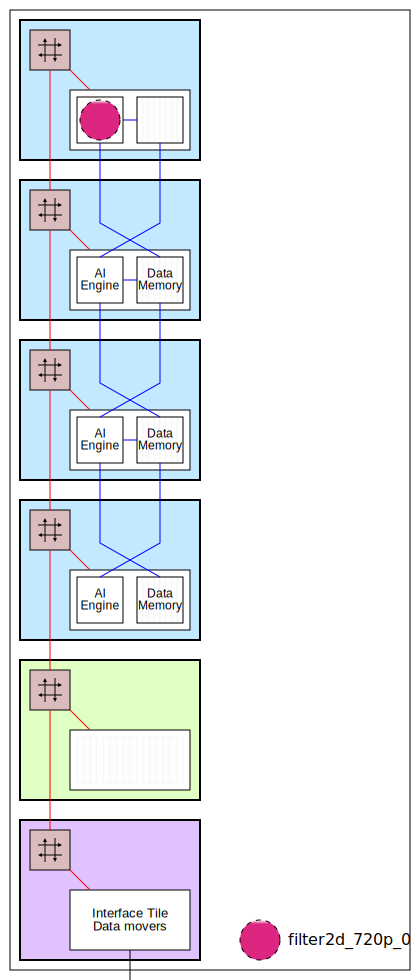

In [3]:
# define input and output grayscale buffers

x_in = np.zeros(shape=(720, 1280), dtype=np.uint8)
x_out = np.zeros(shape=(720, 1280), dtype=np.uint8)

app_builder = SobelY()
app_builder(x_in, x_out)

app_builder.display()

In [5]:
app_builder.build(x_in, x_out)

Building the filter2d_720p kernel...
Building the xclbin...
Successfully Building Application... InverseEdgeDetectApplication.xclbin & InverseEdgeDetectApplication.seq delivered


In [6]:
from npu.utils import OpenCVImageReader, image_plot
from npu.runtime import AppRunner

app = AppRunner('SobelY.xclbin')


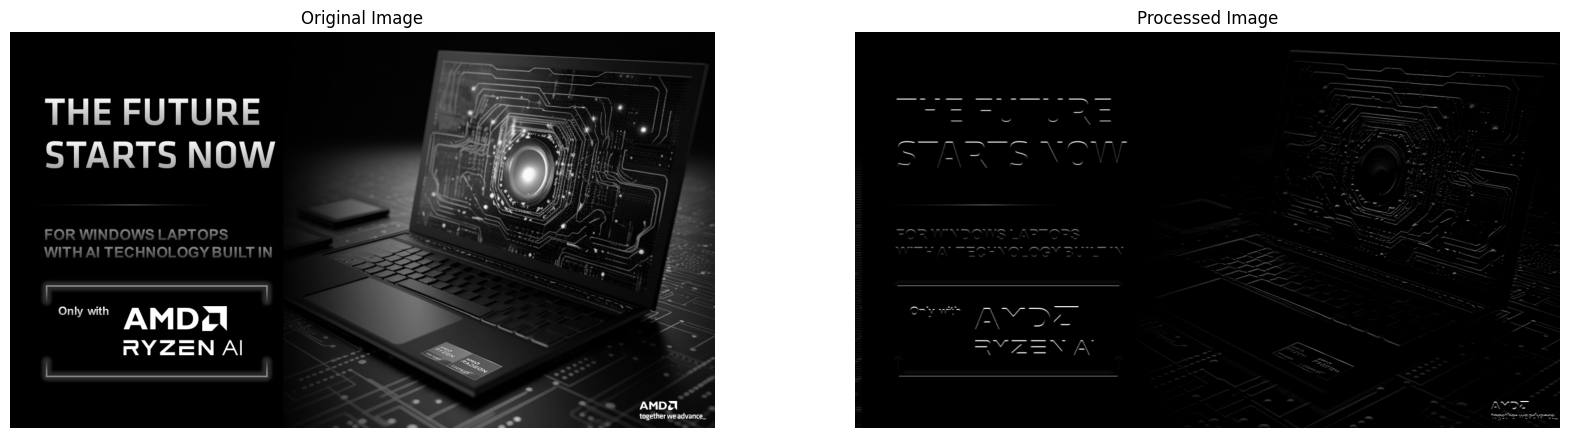

In [16]:

# Allocate app input and output buffers to exchange data with NPU
input_image = app.allocate(shape=(720, 1280), dtype=np.uint8)
output_image = app.allocate(shape=(720, 1280), dtype=np.uint8)

# Load RGBA 720p image into input_image buffer
img = OpenCVImageReader('../images/jpg/ryzenai_future_starts_now.jpg', grayscale=True).img
input_image[:] = img
# Pass input_image buffer to NPU
input_image.sync_to_npu()

# Run app on NPU
app.call(input_image, output_image)

# Get results from NPU via output_image buffer
output_image.sync_from_npu()

image_plot(input_image, output_image)

In [17]:
# save one result
out1 = output_image.copy()

In [19]:
# compare two results
np.sum(output_image - out1)

PynqBuffer(0, dtype=uint32)